In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pygsp import graphs
from additional_utils import create_SBM, AR_index, generate_concentric_circles
import networkx as nx
from sklearn.cluster import KMeans

/home/nicolas/anaconda3/envs/pygsp_tutorial_graphsip/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


# 2 Spectral Graph Theory

We'll see here two of the most celebrated algorithms stemming from Spectral Graph Theory:
1. [Spectral clustering](https://en.wikipedia.org/wiki/Spectral_clustering): clustering data using a similarity graphs
1. [Laplacian eigenmaps](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Laplacian_eigenmaps): dimensionality reduction which preserves geodesic distances

**TODO**: look at <https://nbviewer.jupyter.org/github/mdeff/ntds_2017/blob/outputs/assignments/03_solution.ipynb>

## 2.1 The spectrum of a graph

We consider here only undirected graphs, such that the Laplacian matrix is real symmetric, thus diagonalizable in an orthonormal eigenbasis
$$\mathbf{L}=\mathbf{U}\mathbf{\Lambda U}^\top,$$
where $\mathbf{U}=(\mathbf{u}_1|\ldots|\mathbf{u}_N)\in\mathbb{R}^{N\times N}$ is the matrix of orthonormal eigenvectors and $\mathbf{\Lambda} = \text{diag}(\lambda_1,\ldots,\lambda_N)$ is the diagonal matrix of associated sorted eigenvalues:
$$\lambda_1\leq\lambda_2\leq\ldots\leq\lambda_N.$$

Recall that $\lambda_1$ is necessarily $0$ and that $\lambda_2>0$ iff the graph is connected. 

2018-09-07 12:50:51,522:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.23606797749979


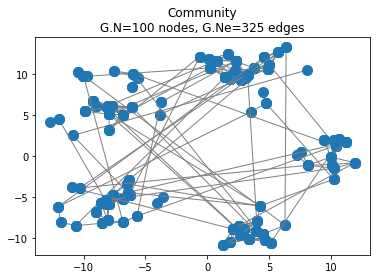

In [2]:
G = graphs.Community(N=100, Nc=5)
G.plot()
eig_val, U = sp.linalg.eigh(G.L.toarray())

Look at ``` eig_val```. Look at ```np.finfo(float).resolution```. How many connected components are in the graph? Check with the networkx function nx.connected_components ```G_nx = nx.from_numpy_matrix(G.A.toarray()); sorted(nx.connected_components(G_nx), key = len, reverse=True)```

Note that we used ```sp.linalg.eigh``` to diagonalize $\mathbf{L}$ because it is the eigensolver optimized for symmetric matrices. Also, ```sp.linalg.eigh``` cannot take sparse matrices as entries. For sparse matrices, optimized eigensolvers exist to obtain the first few eigenvalues and eigenvectors, such as 

In [3]:
eig_val, U = sp.sparse.linalg.eigsh(G.L, k=10, which='SM')

Use option ```which='SM'``` for smallest magnitude search, and ```which='LM'``` for largest magnitude search. ```eigsh``` is nevertheless only made to compute only a few eigenvectors. You will quickly see the utility of ```sp.sparse.linalg.eigsh(G.L, k=10, which='SM')``` versus ```sp.linalg.eigh(G.L.toarray())``` if you increase the size of the network to $10^4$ nodes or larger for instance.

## 2.2. The Stochastic Block Model (SBM)

The Stochastic Block Model (SBM) is a latent variable model of structured random graphs. 
* The set of $N$ nodes is partitioned in $k$ blocks $B_1, \ldots, B_k$ : $\cup_{i} B_i = \{1,\ldots,N\}$ and $\forall i\neq j, B_i\cap B_j = \emptyset$.
* We define a probability matrix $\mathbf{P}\in\mathbb{R}^{k\times k}$ such that $P_{ij}$ is the probability of connection between a node in $B_i$ and a node in $B_j$. 
* To generate an instance of SBM: for each pair of nodes in the graph, draw a Bernoulli random variable of parameter corresponding to their respective blocks.

To simplify, we will suppose that all intra-block probabilities are set to $p_{\text{in}}$ and all inter-block probabilities are set to $p_{\text{out}}$. Also, we will consider only balanced SBMs (ie SBMs whose blocks have same size).

In the case of balanced SBMs, instead of the pair of parameters $(p_{\text{in}}, p_{\text{out}})$, we can consider the pair $(c,\epsilon)$ where $c$ is the average degree of the graph and $\epsilon = \frac{p_{\text{out}}}{p_{\text{in}}}$ is a measure of fuzziness: the larger $\epsilon$, the fuzzier the community structure. The relations between both pairs of parameters are:
 $$p_{\text{in}} = \frac{kc}{N-k+(k-1)\epsilon N}~~~\text{ and }~~~p_{\text{out}} = \frac{kc\epsilon}{N-k+(k-1)\epsilon N}$$
Note that, for a fixed triplet $(\epsilon, N, k)$, $c$ is not a free parameter. 

**The classical inference SBM problem** is: given an instance of an SBM $G$, infer the blocks.

#### Impossibility threshold
In the balanced (ie: all blocks have the same size) and sparse (ie average degree $c=\mathcal{O}(1)$) case, the following phase transition has been shown ([Decelle et al.](https://arxiv.org/pdf/1109.3041.pdf), [Massoulié](https://arxiv.org/pdf/1311.3085.pdf), [Abbe et al.](https://arxiv.org/pdf/1503.00609.pdf)). For a given pair $(k, c)$, there exists a critical fuzziness $\epsilon_c$ such that as $N\rightarrow \infty$:
* if $\epsilon>\epsilon_c$, there exists no algorithm capable of extracting any structural information.
* if $\epsilon<\epsilon_c$, it is *theoretically* possible to retrieve some kind of structural information

with $\epsilon_c = \frac{c - \sqrt{c}}{c + \sqrt{c} (k-1)}$

In [3]:
N = 500; # number of nodes
k = 4; # number of blocks
c = 16; # average degree

com_size = np.ones(k) * (N/k)
com_size = com_size.astype(int)

epsi_c = (c - np.sqrt(c)) / (c + np.sqrt(c) * (k-1)); # critical fuzziness
epsi = epsi_c / 40; # this is a very strong block structure

A, truth = create_SBM(N, k, c, epsi, com_size)
G = graphs.Graph(A)
G.truth = truth

With ```epsi = epsi_c / 40```, ie, a very strong block structure, blocks appear even 'visually' with spring-based plotting algorithms:

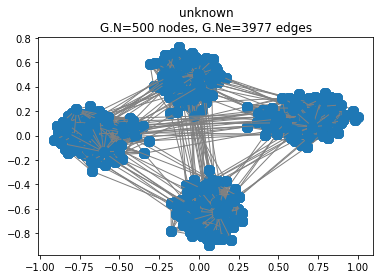

In [4]:
G.set_coordinates(kind='spring') #here with a spring based algorithm
G.plot()

## 2.3. The Eigengap

Let's look at the first few eigenvalues:

In [5]:
eig_val, U = sp.sparse.linalg.eigsh(G.L, k=50, which='SM')

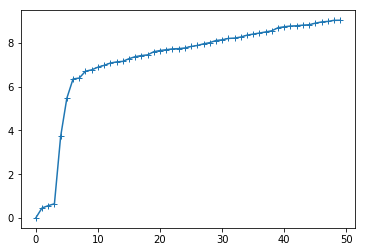

In [6]:
plt.plot(eig_val, '+-')

The large gap between $\lambda_k$ and $\lambda_{k+1}$ is called the "spectral gap": it heuristically appears when there is a strong structure in $k$ communities (even though there exist some theoretical justifications)

### Exercise: eigengap

* Plot a SBM graph with the spring-based plotting algorithm with $\epsilon=\epsilon_c/3$ for instance: one cannot extract communities 'visually' !
* Let's formally define the normalized spectral gap as $\Gamma = \frac{\lambda_{k+1}-\lambda_k}{\lambda_k}$. Plot the average of $\Gamma$ as a function of the fuziness $\epsilon$ in the case of balanced SBM graphs. 

## 2.4 The first few eigenvectors

We have seen that an eigengap usually exists in community-structured graphs. What can we say about the first few eigenvectors? 

Let's plot them in a balanced SBM graph:

In [7]:
N = 500; # number of nodes
k = 4; # number of blocks
c = 16; # average degree

com_size = np.ones(k) * (N/k)
com_size = com_size.astype(int)

epsi_c = (c - np.sqrt(c)) / (c + np.sqrt(c) * (k-1)); # critical fuzziness
epsi = epsi_c / 40; # this is a very strong block structure

A, truth = create_SBM(N, k, c, epsi, com_size)
G = graphs.Graph(A)
G.truth = truth

In [8]:
eig_val, U = sp.sparse.linalg.eigsh(G.L, k=10, which='SM')
G.set_coordinates(kind='spring')

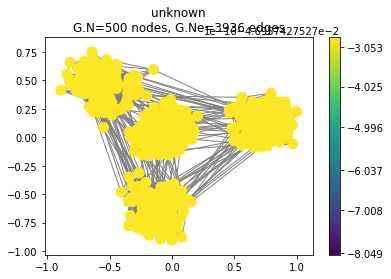

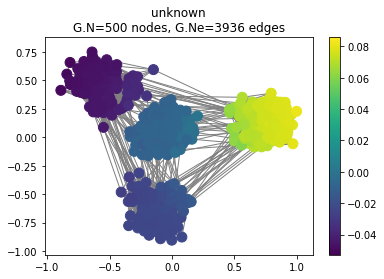

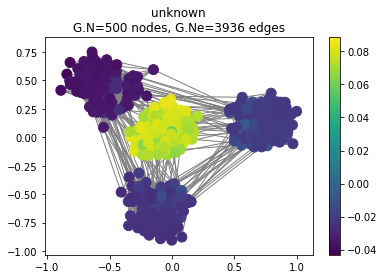

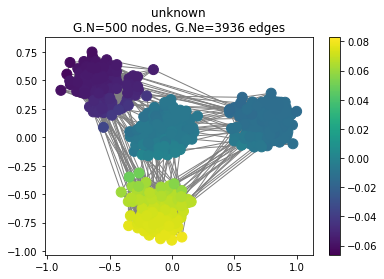

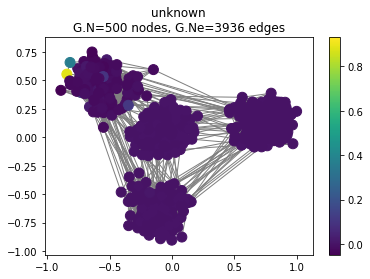

In [9]:
G.plot_signal(U[:,0])
G.plot_signal(U[:,1])
G.plot_signal(U[:,2])
G.plot_signal(U[:,3])
G.plot_signal(U[:,4])

Remember that:
$$\lambda_k=\mathbf{u}_k^\top\mathbf{L}\mathbf{u}_k=\sum_{i\sim j}\mathbf{W}_{ij} (u_k(i)-u_k(j))^2,$$
such that eigenvectors associated to low eigenvalues tend to be smooth with respect to any path in the network. In block-structured graphs, this usually means quasi-constant within each block. Spectral clustering takes advantage of this property. Let us look at a 3-block structure, for better illustration:

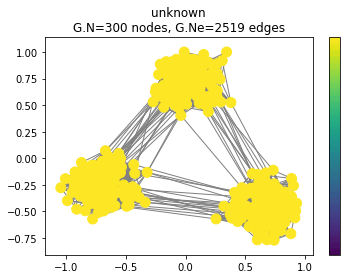

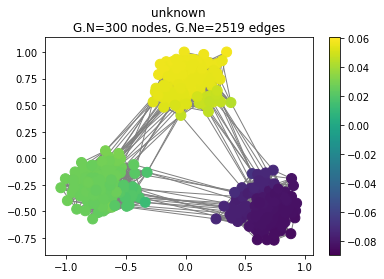

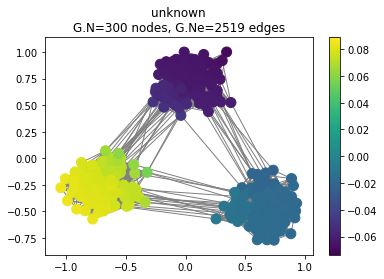

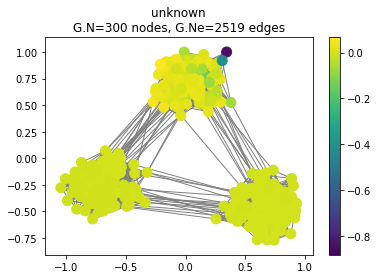

In [10]:
N = 300; # number of nodes
k = 3; # number of blocks
c = 16; # average degree

com_size = np.ones(k) * (N/k)
com_size = com_size.astype(int)

epsi_c = (c - np.sqrt(c)) / (c + np.sqrt(c) * (k-1)); # critical fuzziness
epsi = epsi_c / 40; # this is a very strong block structure

A, truth = create_SBM(N, k, c, epsi, com_size)
G = graphs.Graph(A)
G.truth = truth

eig_val, U = sp.sparse.linalg.eigsh(G.L, k=10, which='SM')
G.set_coordinates(kind='spring')

G.plot_signal(U[:,0])
G.plot_signal(U[:,1])
G.plot_signal(U[:,2])
G.plot_signal(U[:,3])

Say we want to recover in which block belongs each node. The first eigenvector's information is useless (as long as we use the combinatorial Laplacian anyways) as it is constant. A solution is to plot each node $i$ in 2D with coordinates $(u_2(i), u_3(i))$:

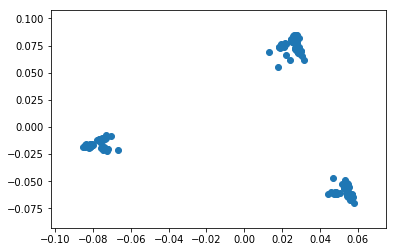

In [11]:
plt.figure()
plt.scatter(U[:,1], U[:,2])

### Exercise: spectral clustering

* Show that, in the last example, performing $k$-means in the $2D$ plane defined by $\mathbf{u}_2$ and $\mathbf{u}_3$ recovers the 3 block structures (the ground truth is in ```G.truth```). For $k$-means, use the function ```KMeans``` in the toolbox ```sklearn.cluster```. To measure performance, you can use the function ```AR_index``` (both functions were already imported in the preamble)
* Given the intuition gained, write a general spectral clustering algorithm that takes as entry a graph $G$, a number of communities $k$, and outputs its community structure in $k$ blocks. 
* Plot the average performance of community mining with this spectral clustering algorithm on balanced SBMs versus the fuziness $\epsilon$. 
* To go further, you can read ["A tutorial on spectral clustering" by U. von Luxburg](https://arxiv.org/pdf/0711.0189.pdf). You will learn among other things that a degree-corrected version is in general preferable (using the normalized Laplacian instead of the combinatorial Lap for instance). For arguments to choose the "best" degree-correction, see ['Improved spectral community detection in large heterogeneous networks' by Tiomoko Ali and Couillet](http://www.jmlr.org/papers/volume18/17-247/17-247.pdf).

## 2.5 Creating the graph
We have seen the spectral clustering algorithm with input a graph $G$. In many cases, however, the input data is simply $N$ vectors in dimension $d$. The construction of the graph is a problem in itself! Let us look at a toy point cloud example where spectral clustering is useful: two concentric circles. 

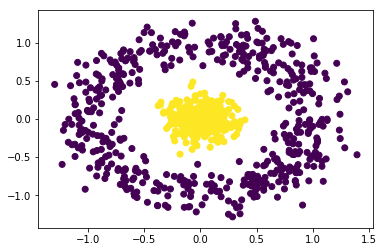

In [5]:
N_in=300 # number of nodes inside
N_out=500 # number of nodes outside
sigma_in= 0.15
sigma_out= 0.15
data, truth = generate_concentric_circles(N_in, N_out, sigma_in, sigma_out)
plt.figure()
plt.scatter(data[:,0], data[:,1], c=truth)

$k$-means will obviously not work on this example. **Exercise: create a similarity graph from the data and perform  SC to recover the 2 communities. Look at Notebook 1 for the two main ways of creating a graph: $k$-nearest neighbours or $\epsilon$-proximity. What is one of the main differences between these two techniques? (regarding the degree distribution for instance) Which technique yields best performances here?**

## 2.2 Laplacian eigenmaps

**TODO**:
* mathematical formulation of the problem
* solution is the first eigenvectors of the Laplacian
* implement with pygsp
* need data with labels: FMA?